In [1]:
!pip install mlflow

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
#import connectorx as cx
import seaborn as sns
import mlflow
from mlflow.models import infer_signature
import shap

In [3]:
data=pd.read_csv('model.csv')
data

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_ncc_pcc,cur_lanes,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place,conn_final_place,volume,conn_volume,conn_tag
0,32215673003,32215673002,1,1,1,1,94,94,10,10,...,2,2,2,55,55,locality,locality,2824,3281,prev
1,46189288001,166038501001,2,2,3,3,84,84,11,11,...,1,3,2,35,35,neighbourhood,neighbourhood,1228,-1,next
2,20110634001,20110634002,1,1,2,2,42,42,4,4,...,1,1,1,25,25,town,town,229,-1,next
3,987686553001,962631300001,1,1,1,1,83,83,11,11,...,2,3,3,50,50,city,city,3255,3725,prev
4,5647861001,5642412001,1,1,1,2,76,76,1,1,...,1,2,1,55,25,town,town,412,7,next
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,5647861002,5647861001,1,1,1,1,76,76,1,1,...,2,2,2,55,55,town,town,405,412,prev
8997,684488140002,684488140001,3,3,6,6,83,83,11,11,...,2,1,1,25,25,city,city,1008,-1,prev
8998,935852141005,24114123001,1,1,1,2,92,92,10,10,...,1,3,1,55,25,locality,locality,527,204,next
8999,20037392001,38624580001,1,1,2,1,36,36,5,5,...,2,1,2,25,65,city,city,40,-1,prev


In [4]:
f_places=set(data['cur_final_place'].unique().tolist()+data['conn_final_place'].unique().tolist())
places={}

for cnt,i in enumerate(f_places):
    places.update({i:cnt})

data['cur_final_place_enc']=list(map(lambda x:places[x],data['cur_final_place']))
data['conn_final_place_enc']=list(map(lambda x:places[x],data['conn_final_place']))
data

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place,conn_final_place,volume,conn_volume,conn_tag,cur_final_place_enc,conn_final_place_enc
0,32215673003,32215673002,1,1,1,1,94,94,10,10,...,2,55,55,locality,locality,2824,3281,prev,2,2
1,46189288001,166038501001,2,2,3,3,84,84,11,11,...,2,35,35,neighbourhood,neighbourhood,1228,-1,next,6,6
2,20110634001,20110634002,1,1,2,2,42,42,4,4,...,1,25,25,town,town,229,-1,next,1,1
3,987686553001,962631300001,1,1,1,1,83,83,11,11,...,3,50,50,city,city,3255,3725,prev,3,3
4,5647861001,5642412001,1,1,1,2,76,76,1,1,...,1,55,25,town,town,412,7,next,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,5647861002,5647861001,1,1,1,1,76,76,1,1,...,2,55,55,town,town,405,412,prev,1,1
8997,684488140002,684488140001,3,3,6,6,83,83,11,11,...,1,25,25,city,city,1008,-1,prev,3,3
8998,935852141005,24114123001,1,1,1,2,92,92,10,10,...,1,55,25,locality,locality,527,204,next,2,2
8999,20037392001,38624580001,1,1,2,1,36,36,5,5,...,2,25,65,city,city,40,-1,prev,3,3


In [5]:
seen_data=data[data['conn_volume']>0]
unseen_data=data[data['conn_volume']<0]
seen_data

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place,conn_final_place,volume,conn_volume,conn_tag,cur_final_place_enc,conn_final_place_enc
0,32215673003,32215673002,1,1,1,1,94,94,10,10,...,2,55,55,locality,locality,2824,3281,prev,2,2
3,987686553001,962631300001,1,1,1,1,83,83,11,11,...,3,50,50,city,city,3255,3725,prev,3,3
4,5647861001,5642412001,1,1,1,2,76,76,1,1,...,1,55,25,town,town,412,7,next,1,1
6,28772519001,352006365001,1,1,2,2,92,92,10,10,...,2,25,25,village,village,292,1740,prev,5,5
7,20197226001,448596015005,1,1,2,1,68,68,8,8,...,2,40,55,town,town,44,1145,prev,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,999149827998001,9991033574469002,2,2,3,3,92,92,10,10,...,1,55,55,locality,locality,1782,1675,next,2,2
8995,382313898001,124083370001,1,1,2,1,76,76,1,1,...,3,55,55,town,city,337,711,prev,1,3
8996,5647861002,5647861001,1,1,1,1,76,76,1,1,...,2,55,55,town,town,405,412,prev,1,1
8998,935852141005,24114123001,1,1,1,2,92,92,10,10,...,1,55,25,locality,locality,527,204,next,2,2


In [35]:
total_feature_lst=['isg_osm_id', 'conn_isg_osm_id', 'cur_fc', 'conn_fc', 'highway_id',
       'conn_highway_id', 'countyid', 'conn_countyid', 'region', 'conn_region',
       'roadwaytype_id', 'conn_roadwaytype_id', 'conn_count', 'conn_ncc_pcc',
       'cur_lanes', 'conn_lanes', 'cur_maxspeed', 'conn_maxspeed',
       'cur_final_place', 'conn_final_place', 'volume', 'conn_volume',
       'conn_tag','cur_final_place_enc','conn_final_place_enc']

input_feature_lst=['cur_fc', 'conn_fc', 'highway_id',
       'conn_highway_id', 'countyid', 'conn_countyid', 'region', 'conn_region',
       'roadwaytype_id', 'conn_roadwaytype_id', 'conn_count', 'conn_ncc_pcc',
       'cur_lanes', 'conn_lanes', 'cur_maxspeed', 'conn_maxspeed',
        'cur_final_place_enc','conn_final_place_enc','volume']

target_feature_lst=['conn_volume']

In [36]:
unique_seen_data=seen_data[input_feature_lst+target_feature_lst].drop_duplicates()
unique_seen_data.shape

(4834, 20)

In [40]:
def log_model_summary(model,X_train,X_val,X_test,y_train,y_val,y_test):
    
    
    test_data=X_test.copy()
    test_data['conn_volume']=y_test['conn_volume']
    test_data['predicted_conn_volume']=y_pred
    test_data['predicted_conn_volume']=test_data['predicted_conn_volume'].round().astype(int)
    test_data['diff']=test_data['conn_volume']-test_data['predicted_conn_volume']
    test_data['geh_value']=test_data.apply(lambda row:geh_check(row['conn_volume'],row['predicted_conn_volume']),axis=1)
    test_data['geh_value']=test_data['geh_value'].round(2)
    
    #Log Parameters
    params=model.get_params()
    mlflow.log_params(params)

    # Log Metrics
    mse = round(mean_squared_error(y_test, y_pred),3)
    rmse = round(np.sqrt(mse),3)
    r2 = round(r2_score(y_test, y_pred),3)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2score =  round((1 - (1 - r2) * (n - 1) / (n - p - 1)),3)
    mae = round(mean_absolute_error(y_test, y_pred),3)
    
    m_geh = round(mean_geh(y_test.values, y_pred),3)
    geh_grt_5 = test_data[test_data['geh_value']>5].shape[0]
    geh_error_per = round(((geh_grt_5/X_test.shape[0])*100),3)
    
    metrics = {'mse':mse,'rmse':rmse,'r2score':r2,'mae':mae,'adjusted_r2score' : adjusted_r2score,
               'mean_geh':m_geh,'geh_grt_5':geh_grt_5,'geh_error':geh_error_per,'geh_error_per':geh_error_per}
    
    mlflow.log_metrics(metrics)
    
    
     # log tags
    tags = {'Model_Name' : 'Stacking',
            
            'Train Size' : X_train.shape[0],
            'Valid Size' : X_val.shape[0],
            'Test Size' : X_test.shape[0],
            'No. Of Input Feature' : len(input_feature_lst),
            'No. Of Target Feature ': len(target_feature_lst),
            'input_feature_lst':input_feature_lst,
            'target_feature_lst': target_feature_lst}
    
    mlflow.set_tags(tags)
    
    return test_data

In [9]:
def geh_check(c_vol,n_vol):
    cur_vol=c_vol
    next_vol=n_vol
    geh_value=float(np.sqrt(2*np.sum((cur_vol-next_vol)**2)/np.sum(cur_vol+next_vol)))
    
    return geh_value

In [29]:
import statistics
def mean_geh(c_vol,n_vol):
    geh_lst=[]
    
    for i,j in zip(c_vol,n_vol):
        geh_lst.append(geh_check(i,j))
    
    return statistics.mean(geh_lst)

In [23]:
def stacking_model(X_train,X_val,X_test,y_train,y_val,y_test):
    
    params= {'subsample': 0.8, 'n_estimators': 10000, 'max_depth': 8,'learning_rate': 0.02, 
             'colsample_bytree': 0.8, 'gamma' : 5 , 'tree_method': 'exact', 'alpha': 5, 'lambda': 5,
             'min_child_weight':5,
            'objective': 'count:poisson','base_score': np.log(np.mean(y_train)),
             'early_stopping_rounds': 20, 'eval_metric': ['rmse', 'mae']}
    
    #XGBRegressor
    eval_set=[(X_train,y_train),(X_val,y_val)]
    xgb_reg=xgb.XGBRegressor(**params)
    xgb_reg.fit(X_train,y_train,eval_set=eval_set)
    xgb_val_pred=xgb_reg.predict(X_val)
    xgb_test_pred=xgb_reg.predict(X_test)
 
    
    #AdaBoost
    adaboost=AdaBoostRegressor(n_estimators=10000,learning_rate=0.02)
    adaboost.fit(X_train,y_train)
    ada_val_pred=adaboost.predict(X_val)
    ada_test_pred=adaboost.predict(X_test)
    
    val_set=X_val.copy()
    val_set['xgb']=xgb_val_pred
    val_set['ada']=ada_val_pred
    test_set=X_test.copy()
    test_set['xgb']=xgb_test_pred
    test_set['ada']=ada_test_pred
  
    
    return val_set,test_set

In [38]:
X,y=unique_seen_data[input_feature_lst],unique_seen_data[target_feature_lst]
X_train,X_temp,y_train,y_temp=train_test_split(X,y,train_size=0.7,random_state=42)             #Test
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,train_size=0.5,random_state=42)       #Validation

In [17]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
tracking_uri=mlflow.get_tracking_uri()
print("Tracking URI:",tracking_uri)

Tracking URI: http://127.0.0.1:5000


In [41]:
#experiment_name = "TurningMovement_Latest"
#experiment = mlflow.set_experiment(experiment_name)
#experiment_id = experiment.experiment_id
run_name = 'AdaBoost_with_fc_123_run without capacity'
description = 'prediction of conn_volume where (pcc=1 and prev_ncc>1) and (ncc>1 and next_pcc=1) for fc 1,2,3'
# Get Experiment Details
#print(f"Experiment_id: {experiment.experiment_id}")
print(f"Run Name: {run_name}")
print(f"Description: {description}")
# print(f"Artifact Location: {experiment.artifact_location}")

Run Name: AdaBoost_with_fc_123_run without capacity
Description: prediction of conn_volume where (pcc=1 and prev_ncc>1) and (ncc>1 and next_pcc=1) for fc 1,2,3


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NotFittedError: need to call fit or load_model beforehand

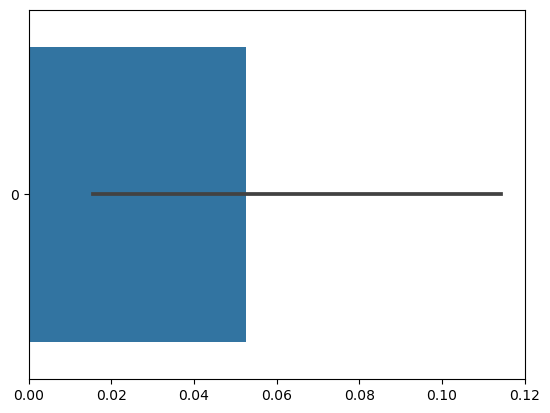

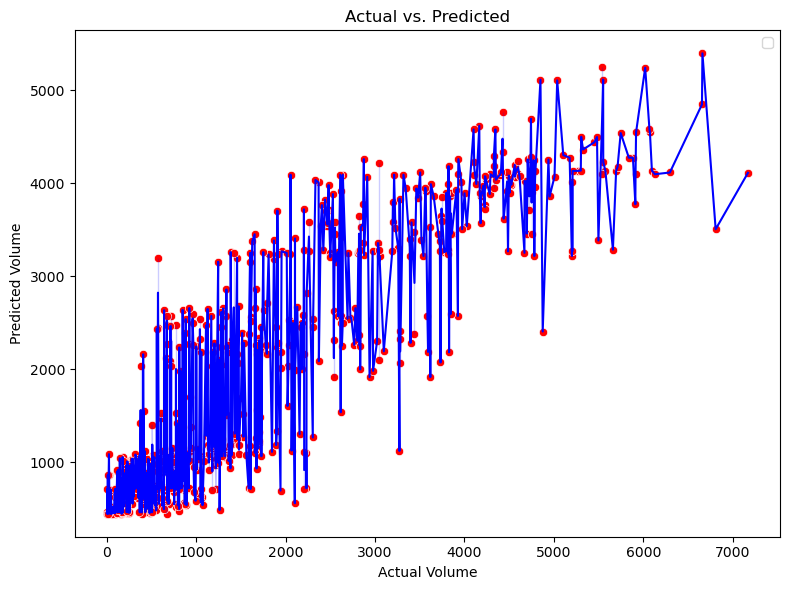

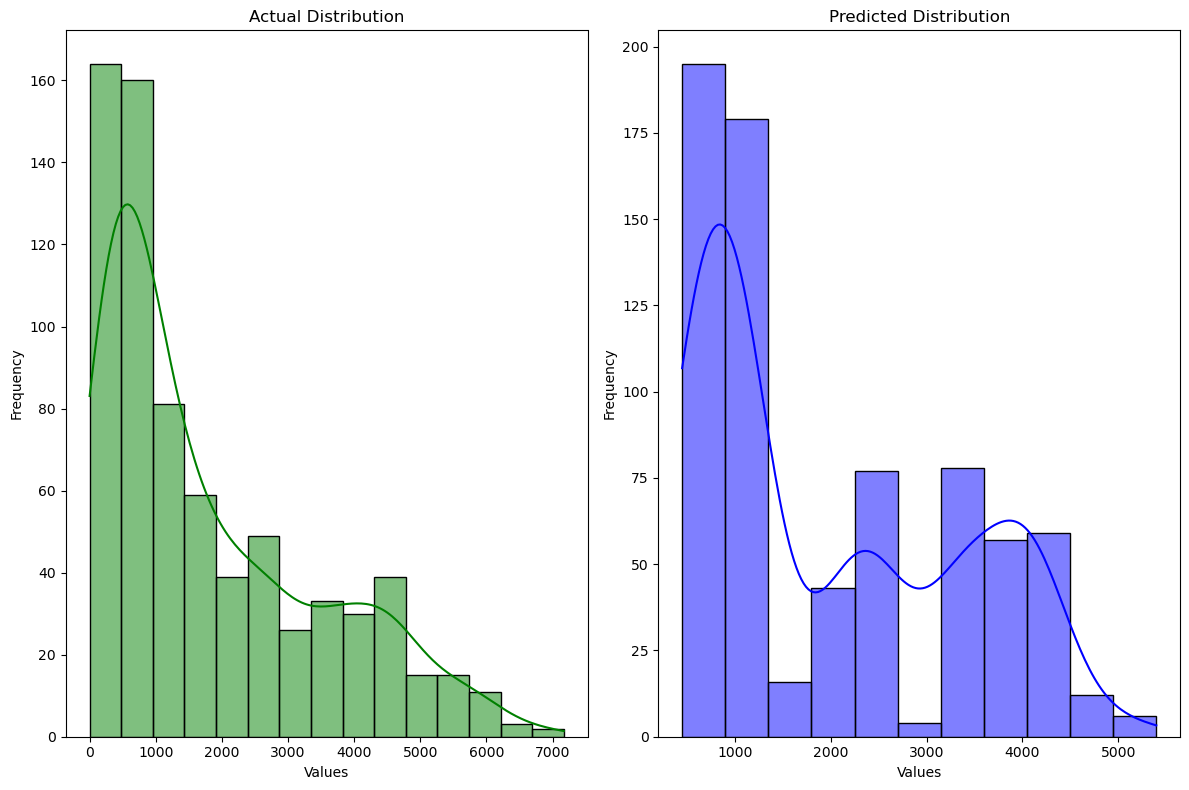

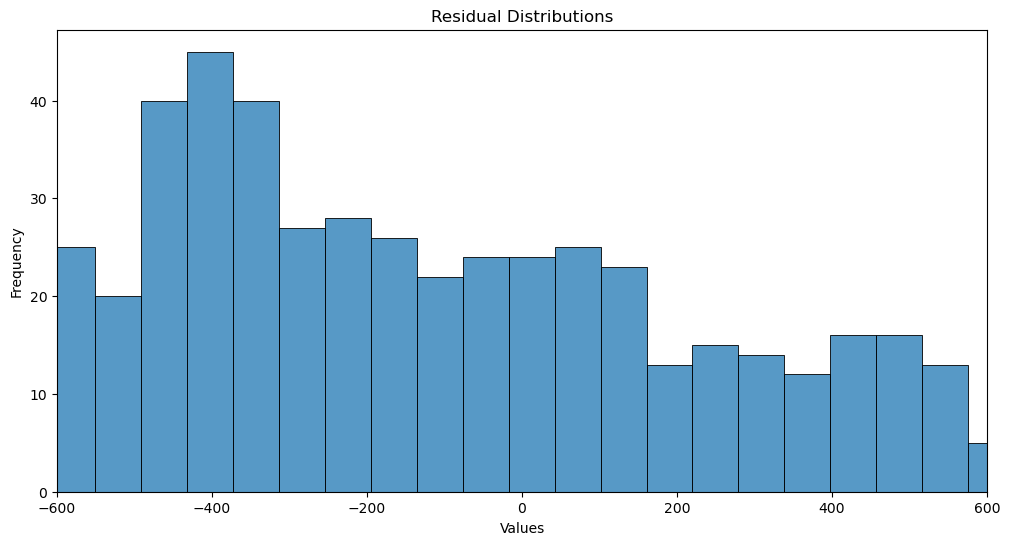

In [47]:
with mlflow.start_run(experiment_id="892707365239548902",run_name=run_name,description=description) as run:

    params= {'subsample': 0.8, 'n_estimators': 10000, 'max_depth': 8,'learning_rate': 0.02, 
             'colsample_bytree': 0.8, 'gamma' : 5 , 'tree_method': 'exact', 'alpha': 5, 'lambda': 5,
             'min_child_weight':5,
            'objective': 'count:poisson','base_score': np.log(np.mean(y_train)),
             'early_stopping_rounds': 20, 'eval_metric': ['rmse', 'mae']}
    
    #AdaBoostRegressor
    ada=AdaBoostRegressor(n_estimators=10000,learning_rate=0.02)
    ada.fit(X_train,y_train)
    y_pred=ada.predict(X_test)
    
    
    #XGBRegressor
    xgb_reg=xgb.XGBRegressor(**params)
    #xgb_reg.set_params(early_stopping_rounds=None)
    
    #Train the model
    eval_set=[(X_train,y_train),(X_val,y_val)]

    #xgb_reg.fit(X_train,y_train,eval_set=eval_set)
    

    
    #mlflow.shap.log_explanation(xgb_reg.predict,X_test)
    
    #Stacking
    #val_set,test_set=stacking_model(X_train,X_val,X_test,y_train,y_val,y_test)
    #xgb_reg.fit(val_set,y_val,eval_set=None,verbose=False)
   
    
    #Make predictions on test set
    #y_pred=xgb_reg.predict(test_set)
    
    
    #Log model summary
    Test_data=log_model_summary(xgb_reg,X_train,X_val,X_test,y_train,y_val,y_test)
    
    #Feature Importance
    
    '''explainer=shap.TreeExplainer(xgb_reg)
    shap_values=explainer.shap_values(test_set)
    fig=shap.summary_plot(shap_values,test_set,plot_type='bar',show=False)
    image_path="Feature_Importance.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path,"images")'''
    
    fi=ada.feature_importances_
    sns.barplot(fi,orient="h")
    image_path="Feature_Importance.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path,"images")
    
    #log learning curve
    ''' results = xgb_reg.evals_result()
    training_rounds = range(len(results['validation_0']['rmse']))
    plt.figure(figsize=(12, 6))
    plt.plot(training_rounds, results['validation_0']['rmse'], label='Training Loss')
    plt.plot(training_rounds, results['validation_1']['rmse'], label='Validation Loss')
    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE') 
    plt.title('XGBoost Training and Validation Loss')
    plt.legend()

    image_path = "Learning_Curve.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, "images")'''
    
    #Actual vs. Predictions
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=Test_data,x='conn_volume',y='predicted_conn_volume',color='red' )
    sns.lineplot(x=Test_data['conn_volume'],y=Test_data['predicted_conn_volume'],color='blue')
    plt.title('Actual vs. Predicted')
    plt.xlabel('Actual Volume')
    plt.ylabel('Predicted Volume')
    plt.legend()
    plt.tight_layout()
    image_path="Actual_vs_Prediction_PLot.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path,"images")
    
    #Actual vs. Prediction Distribution
    fig,axes=plt.subplots(1,2,figsize=(12,8))
    sns.histplot(Test_data['conn_volume'],color='green',kde=True,ax=axes[0])
    axes[0].set_title("Actual Distribution")
    axes[0].set_xlabel("Values")
    axes[0].set_ylabel("Frequency")
    sns.histplot(Test_data['predicted_conn_volume'],color='blue',kde=True,ax=axes[1])
    axes[1].set_title("Predicted Distribution")
    axes[1].set_xlabel("Values")
    axes[1].set_ylabel("Frequency")
    plt.tight_layout()

    image_path="Actual_vs_Prediction_Distribution.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path,"images")
    
    #Residuals
    plt.figure(figsize=(12,6))
    sns.histplot(Test_data['diff'],bins=100,kde=False)
    plt.title("Residual Distributions")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.xlim(-600,600)

    image_path="Residual_PLot.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path,"images")
    
    #Log Model
    signature=infer_signature(X_test,ada.predict(X_test))
    mlflow.sklearn.log_model(ada,"model",signature=signature)
    
    mlflow.end_run()

In [23]:
X_train['conn_volume']=y_train['conn_volume']

In [24]:
X_train=pd.merge(seen_data[['isg_osm_id','conn_isg_osm_id']],X_train,left_index=True,right_index=True)
X_train

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_count,conn_ncc_pcc,cur_lanes,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place_enc,conn_final_place_enc,volume,conn_volume
0,32215673003,32215673002,1,1,1,1,94,94,10,10,...,1,2,2,2,55,55,3,3,2824,3281
3,987686553001,962631300001,1,1,1,1,83,83,11,11,...,1,2,3,3,50,50,5,5,3255,3725
4,5647861001,5642412001,1,1,1,2,76,76,1,1,...,2,1,2,1,55,25,2,2,412,7
6,28772519001,352006365001,1,1,2,2,92,92,10,10,...,1,2,1,2,25,25,4,4,292,1740
7,20197226001,448596015005,1,1,2,1,68,68,8,8,...,1,2,1,2,40,55,2,2,44,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,39352199002,20111580001,1,1,1,2,42,42,4,4,...,2,1,2,1,55,40,2,2,2022,281
8988,538843228001,25429543001,1,1,2,2,83,83,11,11,...,1,2,1,1,50,50,5,5,1210,1630
8990,32131901003,24115658001,1,1,1,2,92,92,10,10,...,2,1,3,1,55,25,3,3,2318,351
8996,5647861002,5647861001,1,1,1,1,76,76,1,1,...,1,2,2,2,55,55,2,2,405,412


In [25]:
Test_data=pd.merge(seen_data[['isg_osm_id','conn_isg_osm_id']],Test_data,left_index=True,right_index=True)

In [26]:
Test_data

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place_enc,conn_final_place_enc,volume,conn_volume,predicted_conn_volume,diff,geh_value
18,5709074001,1001322976001,1,1,2,1,83,83,11,11,...,3,25,50,5,5,416,3707,3761,-54,0.88
23,5700479001,539226006001,1,1,2,2,83,83,11,11,...,1,25,25,5,5,1376,2208,1752,456,10.25
29,99868338638003,99868338638002,3,3,5,5,82,82,11,11,...,2,25,25,5,5,513,613,681,-68,2.67
36,20178541001,139603051001,2,2,4,3,94,94,10,10,...,3,25,55,3,3,640,2621,2203,418,8.51
46,345094114001,45409658001,1,1,1,1,52,52,3,3,...,2,55,55,2,5,1092,1214,1218,-4,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,654295295002,654295295001,3,3,5,5,89,89,11,11,...,2,25,25,5,5,582,807,794,13,0.46
8963,957791472001,957791471001,1,1,1,1,82,82,11,11,...,4,45,45,0,0,3044,3562,2871,691,12.18
8965,20130995001,20130995002,1,1,2,2,60,60,2,2,...,1,45,45,5,5,503,100,270,-170,12.50
8982,5696052001,46680566001,1,1,2,1,89,89,11,11,...,3,25,50,5,5,784,2466,3777,-1311,23.47


In [27]:
unseen_pred=xgb_reg.predict(unseen_data[input_feature_lst])
unseen_pred

array([ 881.99677,  129.20917, 3213.0776 , ...,  606.81104,  858.04315,
        537.5322 ], dtype=float32)

In [28]:
unseen_data['conn_volume']=unseen_pred
unseen_data['conn_volume']=unseen_data['conn_volume'].round().astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
unseen_data

,isg_osm_id,conn_isg_osm_id,cur_fc,conn_fc,highway_id,conn_highway_id,countyid,conn_countyid,region,conn_region,...,conn_lanes,cur_maxspeed,conn_maxspeed,cur_final_place,conn_final_place,volume,conn_volume,conn_tag,cur_final_place_enc,conn_final_place_enc
1,46189288001,166038501001,2,2,3,3,84,84,11,11,...,2,35,35,neighbourhood,neighbourhood,1228,882,next,0,0
2,20110634001,20110634002,1,1,2,2,42,42,4,4,...,1,25,25,town,town,229,129,next,2,2
5,124369932003,124369932004,1,1,1,1,42,42,4,4,...,3,55,55,city,city,3901,3213,next,5,5
11,12719627001,40118581001,1,1,2,1,57,57,9,9,...,2,25,65,town,town,5,341,prev,2,2
16,44164413001,195743216001,3,3,5,5,84,84,11,11,...,3,25,25,neighbourhood,neighbourhood,174,784,prev,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8991,998193989441005,998193989441004,3,3,5,5,94,94,10,10,...,2,40,40,locality,locality,252,422,prev,3,3
8992,1044700779002,20180331001,1,1,1,2,94,94,10,10,...,1,55,25,locality,locality,4287,395,next,3,3
8993,1025754084001,1025754084002,2,2,3,3,86,86,8,8,...,2,55,55,town,town,626,607,next,2,2
8997,684488140002,684488140001,3,3,6,6,83,83,11,11,...,1,25,25,city,city,1008,858,prev,5,5
